In [1]:
# !unzip in_data/data-compressed.zip

In [2]:
#imports, need to only run this once
!pip3 install numpy 
!pip3 install pandas 
!pip3 install torch torchvision 
!pip3 install scikit-learn
!pip3 install xgboost
!pip3 install category_encoders
!pip3 install shap

# SOFTMAX MODEL

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'

# replace str to binary
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
X = train_features[~tr_mask]
y = train_targets_scored[~tr_mask]


#removing sig_id column 
X = X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.3333, random_state=42)

(4390, 206)


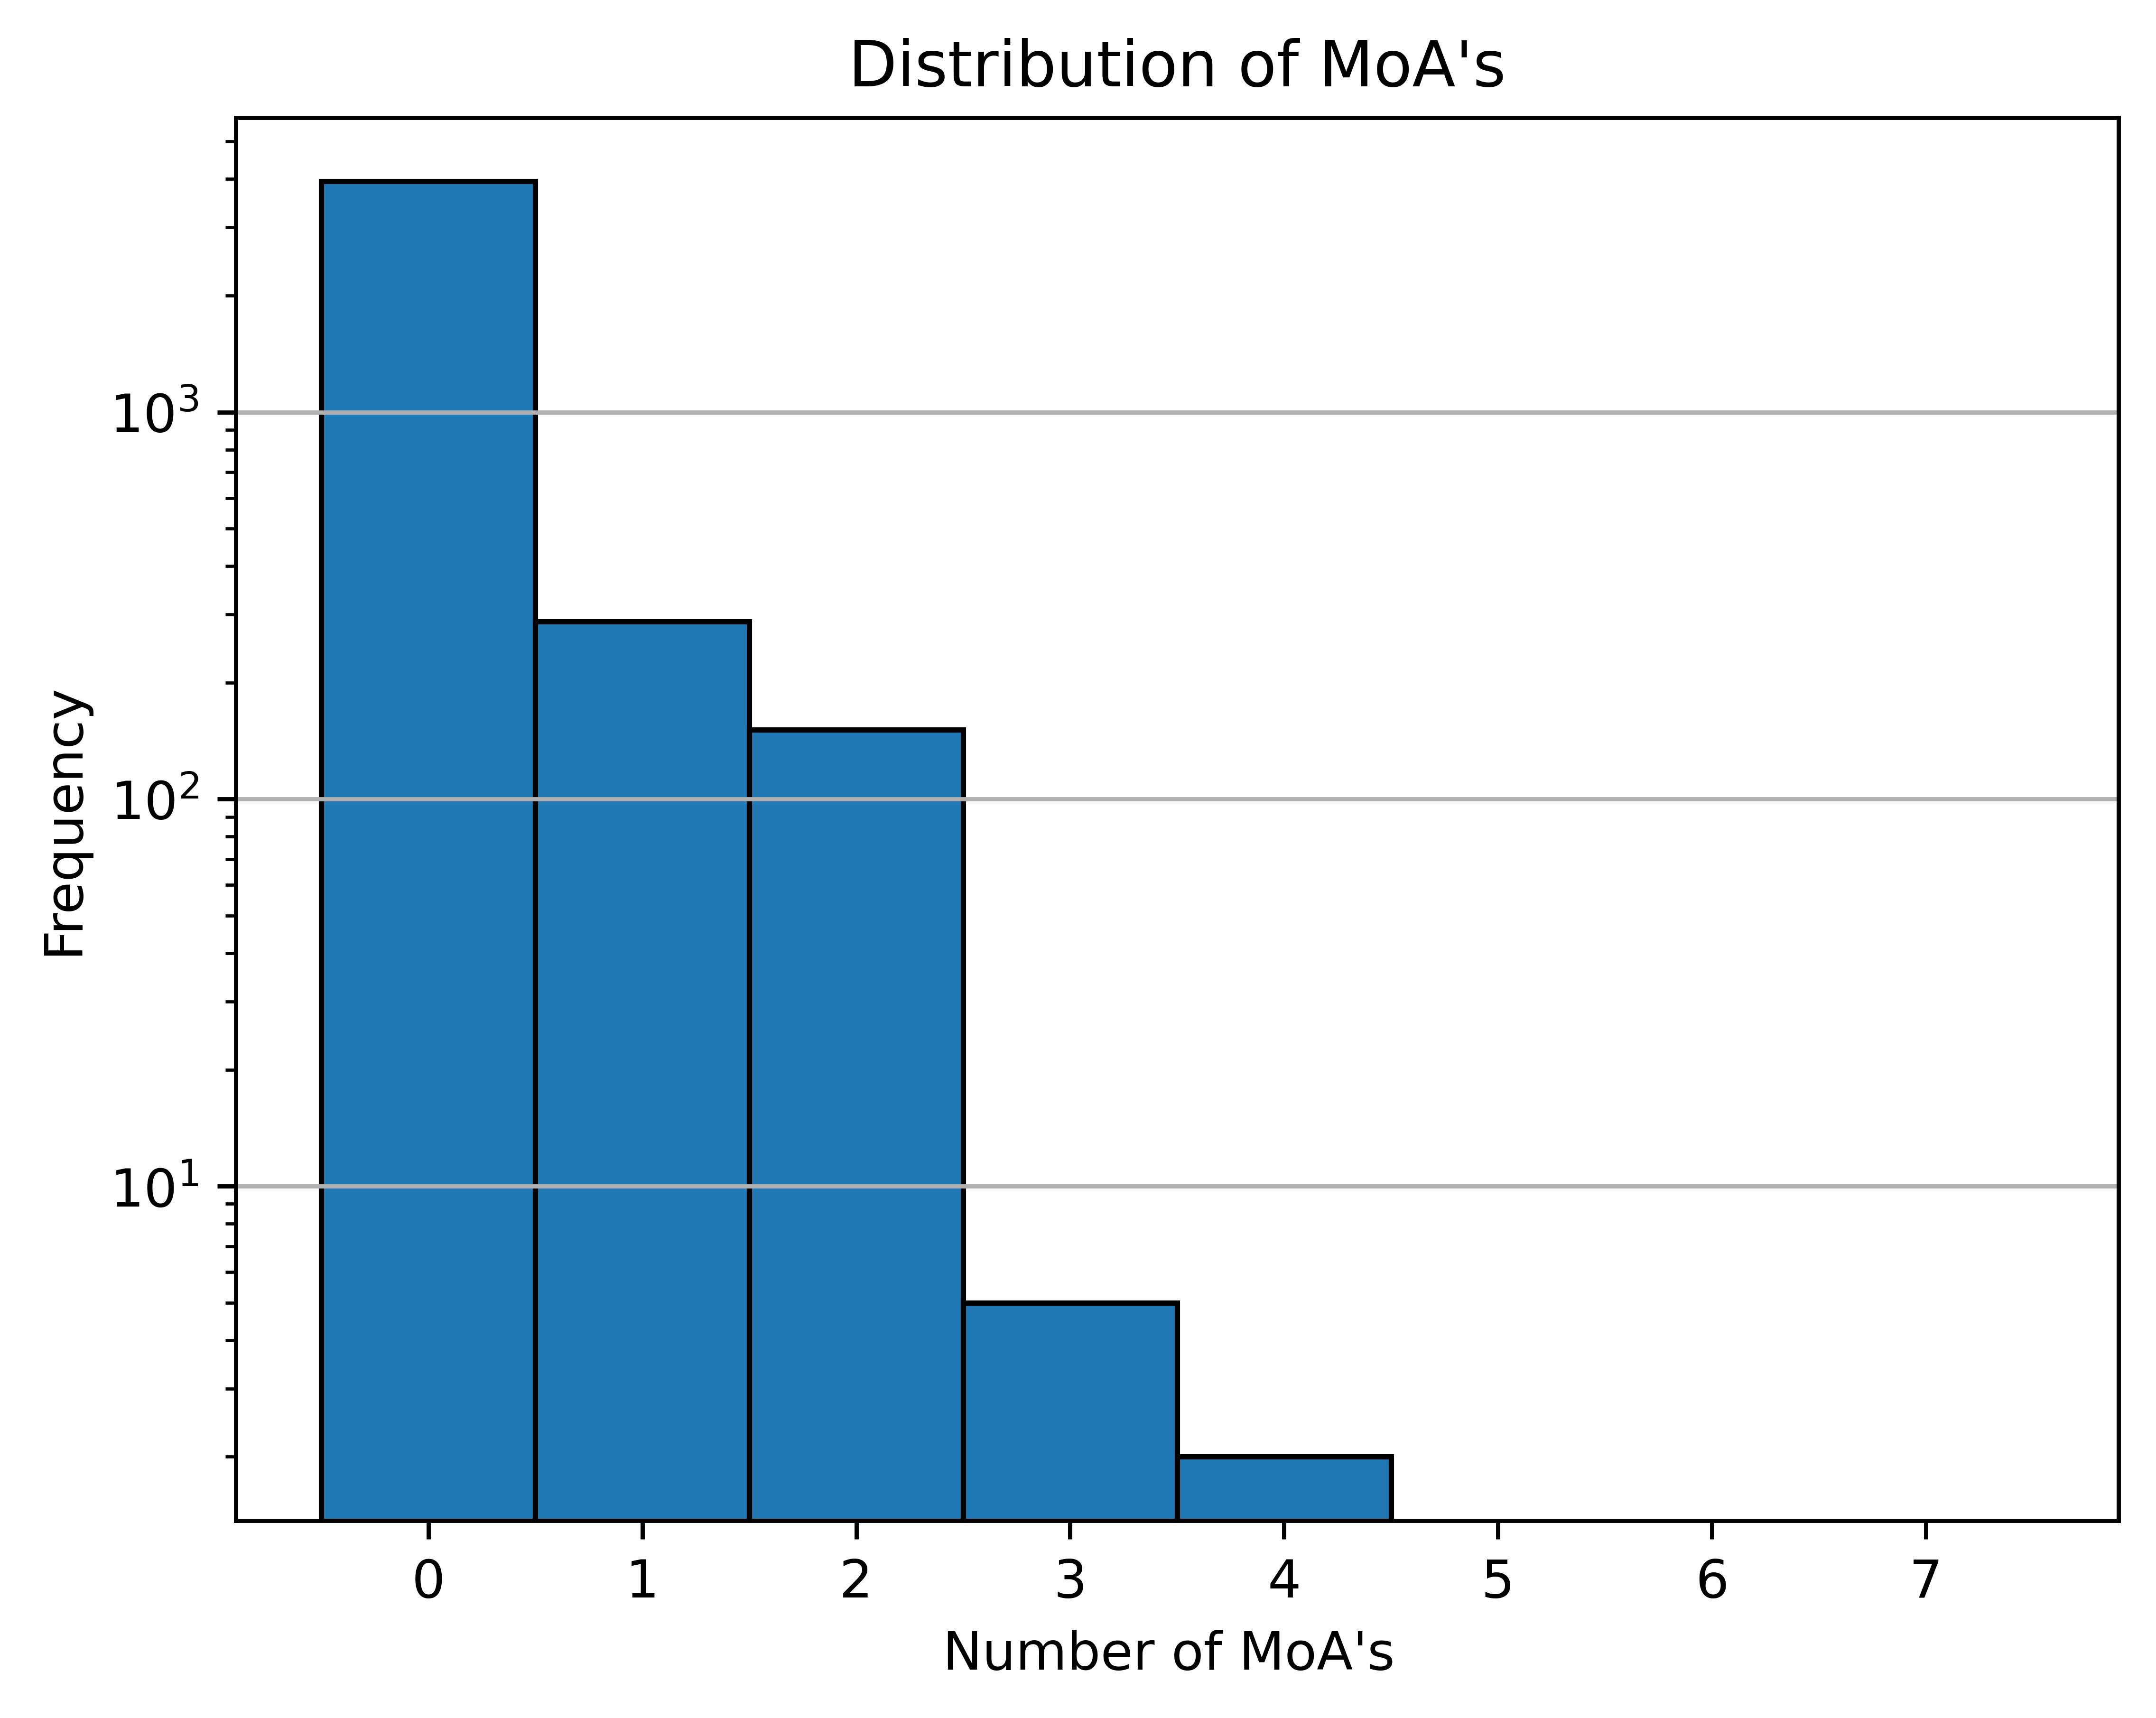

Average Loss: 0.0253, Accuracy: 0.9968
Precision: 0.8809, Recall: 0.1598, F1 Score: 0.2705


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt 

pred_labels = []
# Define your model architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out


def train(model, train_loader, num_epochs, criterion, optimizer, l1_lambda=0.001):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # No need to convert labels to float here
            
            # L1 regularization
            # l1_reg = torch.tensor(0., requires_grad=False)
            # for param in model.parameters():
            #     l1_reg += torch.norm(param.detach(), p=1)
            # loss += l1_lambda * l1_reg

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    

 

def evaluate(model, test_loader, criterion):
    # Set the model in evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # Convert probabilities to binary predictions
            predicted_labels = (outputs > 0.5).float()

            # Store true and predicted labels for later computation
            true_labels.extend(labels.cpu().numpy().flatten())
            pred_labels.extend(predicted_labels.cpu().numpy().flatten())

            # Compute accuracy
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)*labels.size(1)

            

    # Calculate average loss
    average_loss = total_loss / len(test_loader.dataset)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    # Calculate precision, recall, and F1 score using scikit-learn
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    f = plt.figure(dpi=800)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.reshape(y_test.shape[0], y_test.shape[1])
    print(pred_labels.shape)
    # print(pred_labels.shape)
    
    # print(disp_y.shape)
    row_sums = np.sum(pred_labels, axis=1)

    # Plot the distribution
    plt.hist(row_sums, bins=np.arange(9)-0.5, align='mid', edgecolor='black')
    plt.xlabel('Number of MoA\'s ')
    plt.ylabel('Frequency')
    plt.title('Distribution of MoA\'s')
    plt.yscale('log')
    plt.xticks(range(8))
    plt.grid(axis='y')  # Add gridlines for clarity
    plt.show()
    print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


#Define loss function and optimizer
model = MultiLabelClassifier(input_size=X.shape[1], num_classes=206)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Convert labels to probabilities
y_train_prob = y.astype(np.float32)  # Convert to float for torch.tensor
y_test_prob = y_test.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_prob, dtype=torch.float32)  # Use probabilities
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_prob, dtype=torch.float32)  # Use probabilities

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Train the model
train(model=model, train_loader=train_loader, num_epochs=25, criterion=criterion, optimizer=optimizer)
evaluate(model=model, test_loader=test_loader, criterion=criterion)